# Core task 2 : code to get you started

This notebook demonstrates how to use the network_spreading_models toolbox to fit the NDM and FKPP models to some target data.
First, we import the relevant libraries.

If you have set up the environment correctly, the following cell should run without any errors.

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from nsm_toolbox.src import network_diffusion_model, FKPP_model
from nsm_toolbox.src.find_optimal_timepoint import find_optimal_timepoint

from nsm_toolbox.src.ModelSelection import ModelSelection

ModuleNotFoundError: No module named 'nsm_toolbox'

Next, we will load in the target data, which is regional tau-PET SUVR data from the ADNI dataset, averaged across individuals with amyloid and tau pathology.

We min-max normalise the data to the range [0,1], as this is required for the model fitting.

In [2]:
# load in target data
tau = pd.read_csv("data/PET/tau_ab+_tau+.csv", names=["region", "suvr"], header=0)
target_data = tau["suvr"].values

# remove the subcortical regions, since these are affected by off-target binding of the tau-PET tracer
CORT_IDX = np.concatenate([np.arange(34), np.arange(49, 83)])
target_data = target_data[CORT_IDX]

def normalise_data(data):
    ''' min-max normalise the data '''
    return (data - np.min(data)) / (np.max(data) - np.min(data))

target_data = normalise_data(target_data)

# load in the reference list
region_list = pd.read_csv( "data/TauRegionList.csv")["Raj_label"].tolist()

Now we are ready to fit the models to the data.

We will start with the Network Diffusion Model. For now, we will use one of the connectomes from a single cognitively normal individual.

In [3]:
# the path where the connectome is stored
connectome_path = "data/connectomes/CN/CN_0.csv"

# define the timepoints for our model evaluation
t = np.arange(0, 50, 0.1)

# define gamma: the diffusion constant (we set this to 1 since we are not calibrating our time units to any real-world time)
gamma = 1

# set up our network diffusion model class with the connectome, timepoints, gamma, and reference list
ndm = network_diffusion_model.NDM(connectome_fname=connectome_path,
                                  t=t,
                                  gamma = gamma,
                                  ref_list=region_list)

# find the optimal seed region for our dataset
df, optimal_seed = ndm.optimise_seed_region(target_data)
print(optimal_seed)

# run the model with the optimal parameters (in this case, the seed region) and record model fit
ndm.seed_region = optimal_seed["seed"]
model_output = ndm.run_NDM()

# we use find_optimal_timepoint to scan the model output and find the timepoint that best fits the target data
min_idx, prediction, SSE = find_optimal_timepoint(model_output, target_data)

{'seed': 'Temporalpole'}


## Model comparison
Dummy example for 5 models each having 100 obeservations using AICc criterion: 

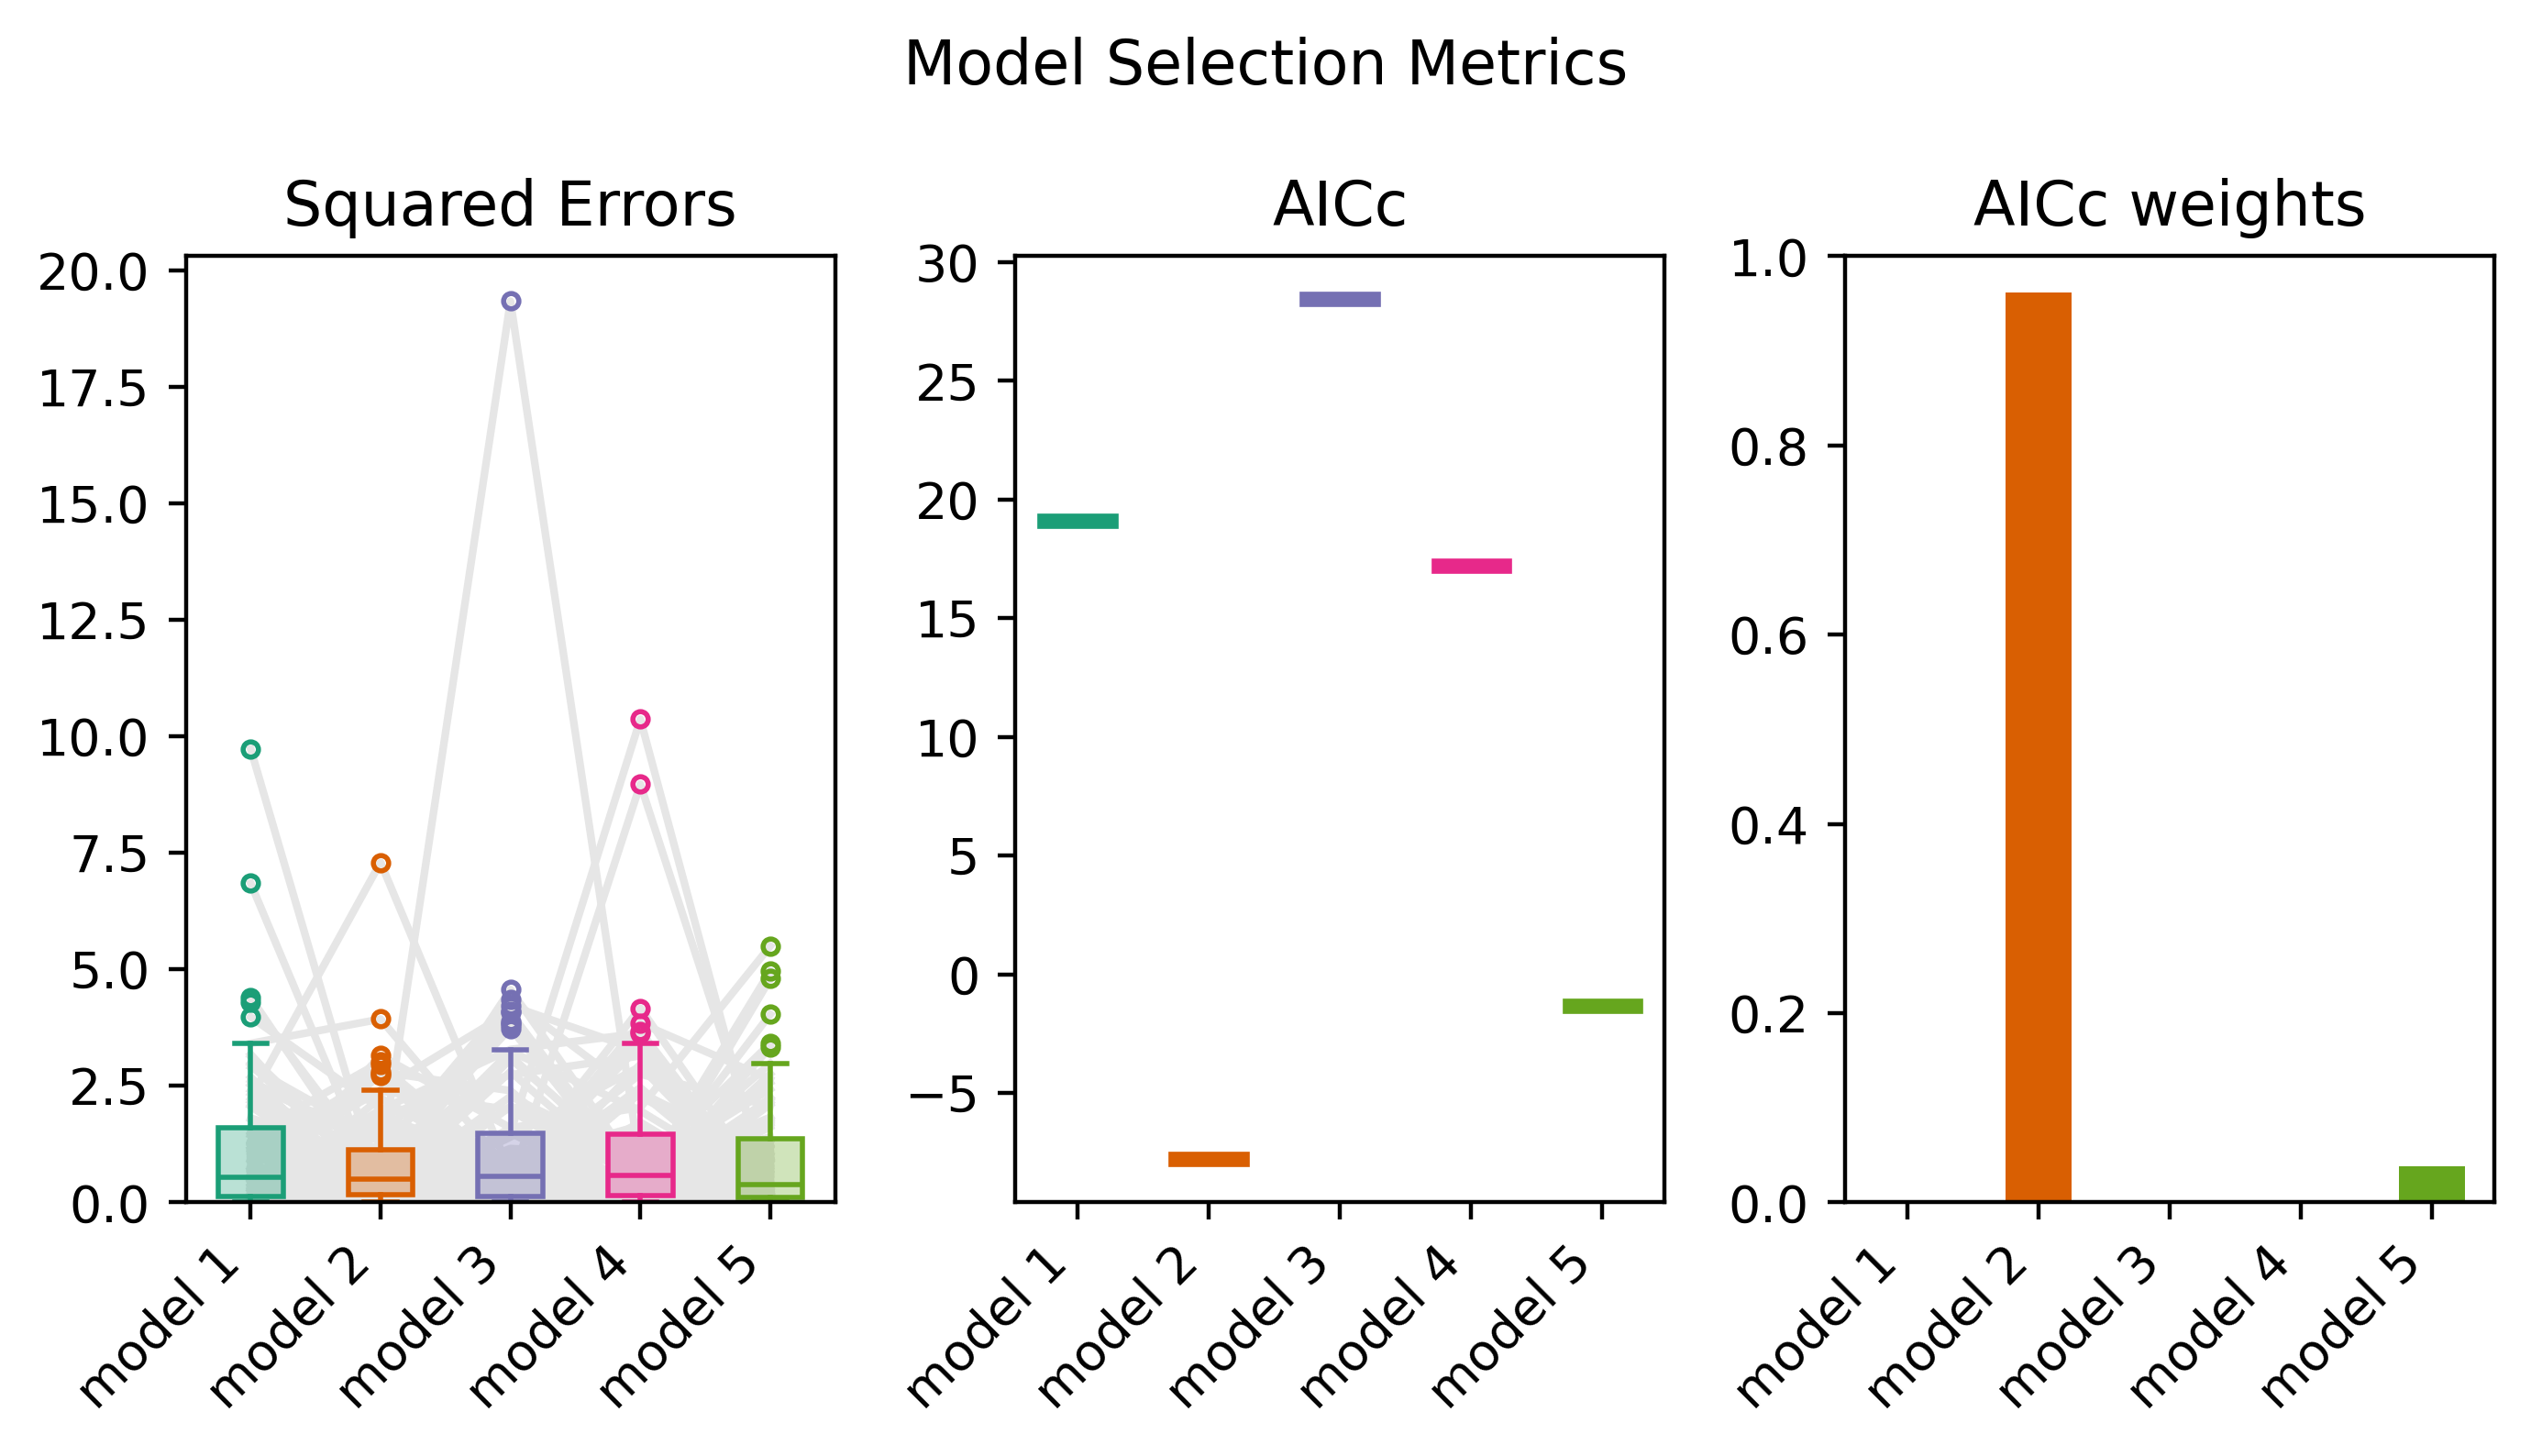

     Model       AICc  AICc weights  rank
0  model 1  19.085211  1.400148e-06     4
1  model 2  -7.795020  9.619267e-01     1
2  model 3  28.439673  1.302802e-08     5
3  model 4  17.206741  3.581613e-06     3
4  model 5  -1.335909  3.806833e-02     2


In [4]:
from nsm_toolbox.src.ModelSelection import ModelSelection

residuals = np.random.normal(size=(100,5))
results = ModelSelection([3,3,4,2,3], 'AICc')(residuals)
print(results)

## Calculate Group-averaged connectomes

In [5]:
groups = ["CN", "EMCI", "LMCI", "DEM"]

expected_size = len(region_list)
expected_shape = (expected_size, expected_size)

# loop over cog. groups
for group in groups:

    # folder path
    group_folder = os.path.join("data", "connectomes", group)

    # list csv files in folder
    connectome_files = [os.path.join(group_folder, f) for f in os.listdir(group_folder) if f.endswith('.csv')]

    # load connectomes
    connectomes = []
    shapes = []
    
    for f in connectome_files:
        matrix = pd.read_csv(f, header=None).values
        shapes.append(matrix.shape)

        n_rows, n_cols = matrix.shape
        if n_rows >= expected_size and n_cols >= expected_size:
            matrix = matrix[:expected_size, :expected_size]
        else:
            padded = np.zeros(expected_shape)
            padded[:n_rows, :n_cols] = matrix
            matrix = padded
            
        connectomes.append(matrix)
    
    # compute averages
    group_avg_connectome = np.mean(np.stack(connectomes, axis=0), axis=0)

    # save the data
    group_avg_path = os.path.join(group_folder, f"group_avg_{group}.csv")
    np.savetxt(group_avg_path, group_avg_connectome, delimiter = ",")

## Run Models

Processing group: CN
NDM optimal seed for CN: {'seed': 'Inferiortemporal'}


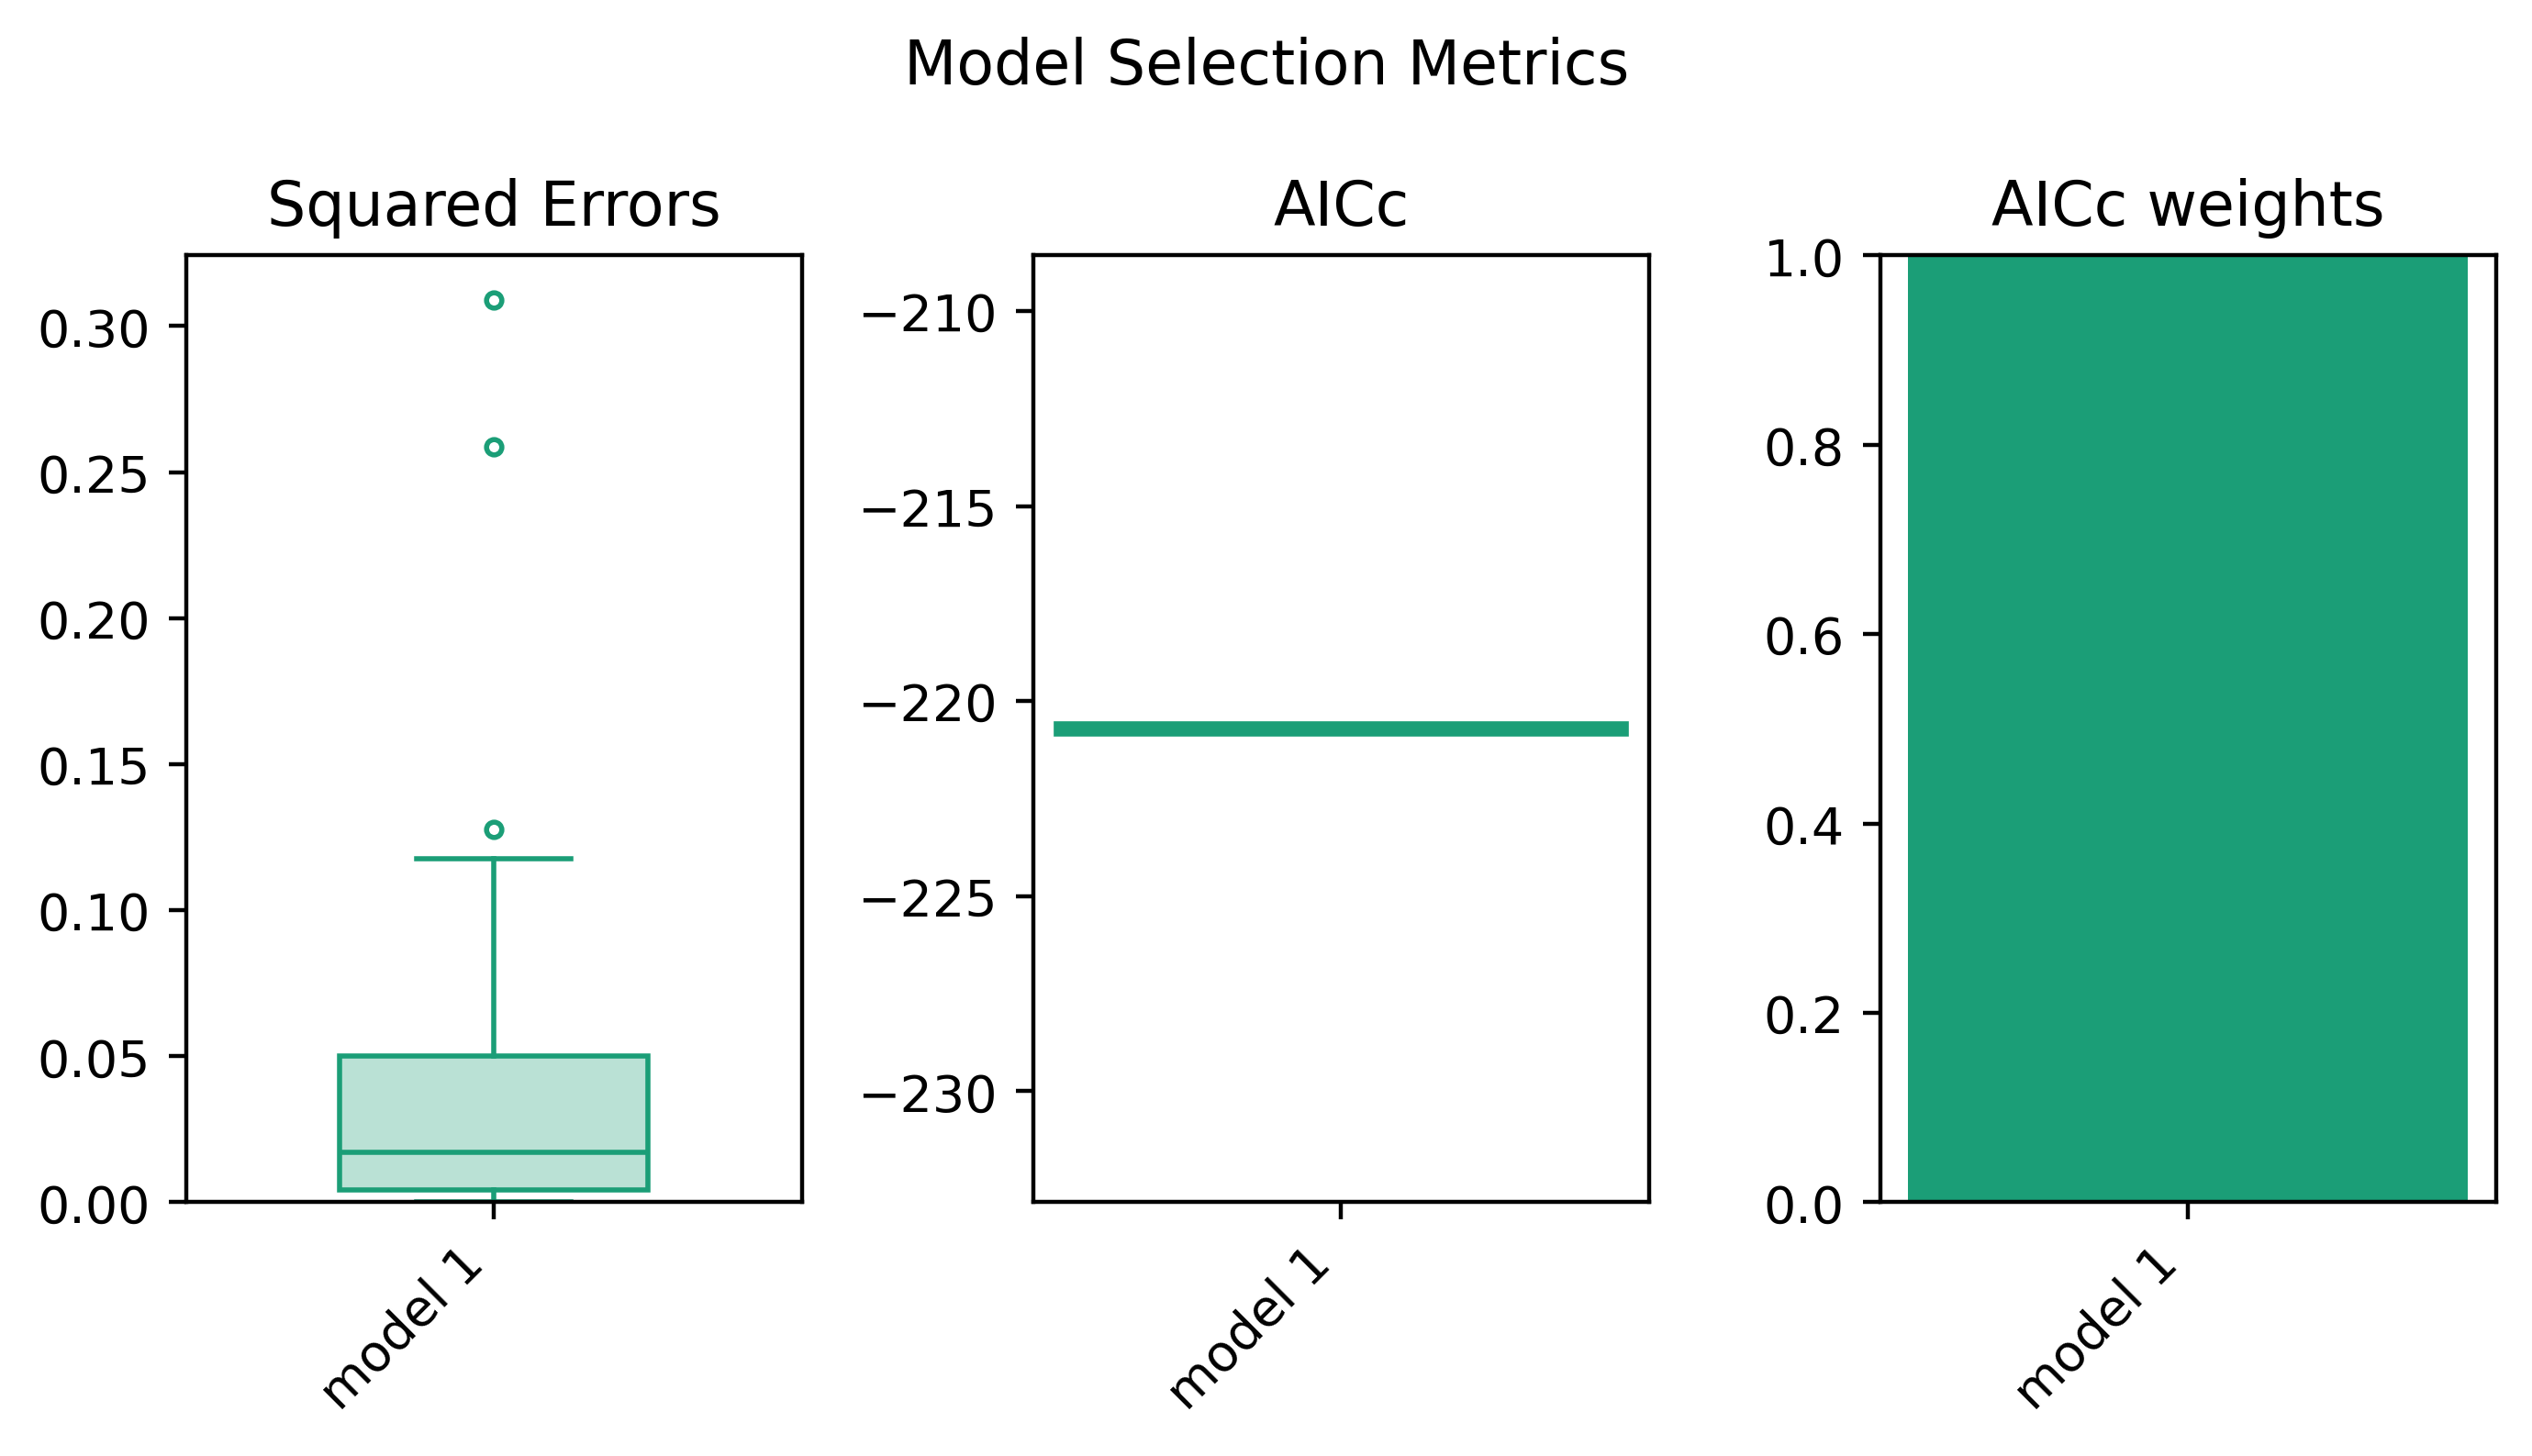

Results for group CN:
NDM {'optimal_seed': {'seed': 'Inferiortemporal'}, 'min_timepoint_index': np.int64(43), 'SSE': np.float64(2.5677088851455947), 'r': np.float64(0.7141830528085821), 'AICc':      Model        AICc  AICc weights  rank
0  model 1 -220.710662           1.0     1, 'prediction': array([0.74961391, 0.12410972, 0.13351517, 0.38480741, 0.7215902 ,
       0.81665797, 0.50684204, 1.        , 0.36530326, 0.55842926,
       0.11393103, 0.51162552, 0.11157892, 0.92863895, 0.59356842,
       0.17338826, 0.13927498, 0.09257595, 0.10698759, 0.43425532,
       0.22511842, 0.20100491, 0.17955669, 0.33199101, 0.10392892,
       0.10625832, 0.12785061, 0.35621887, 0.68225906, 0.3788599 ,
       0.08807597, 0.85810146, 0.57300861, 0.2970419 , 0.65061491,
       0.11837648, 0.12724776, 0.39021929, 0.76418201, 0.79540174,
       0.49811819, 0.93532728, 0.36283635, 0.54504815, 0.12263635,
       0.48524628, 0.09704549, 0.81676463, 0.61218204, 0.17641206,
       0.13376491, 0.09932645, 0.11

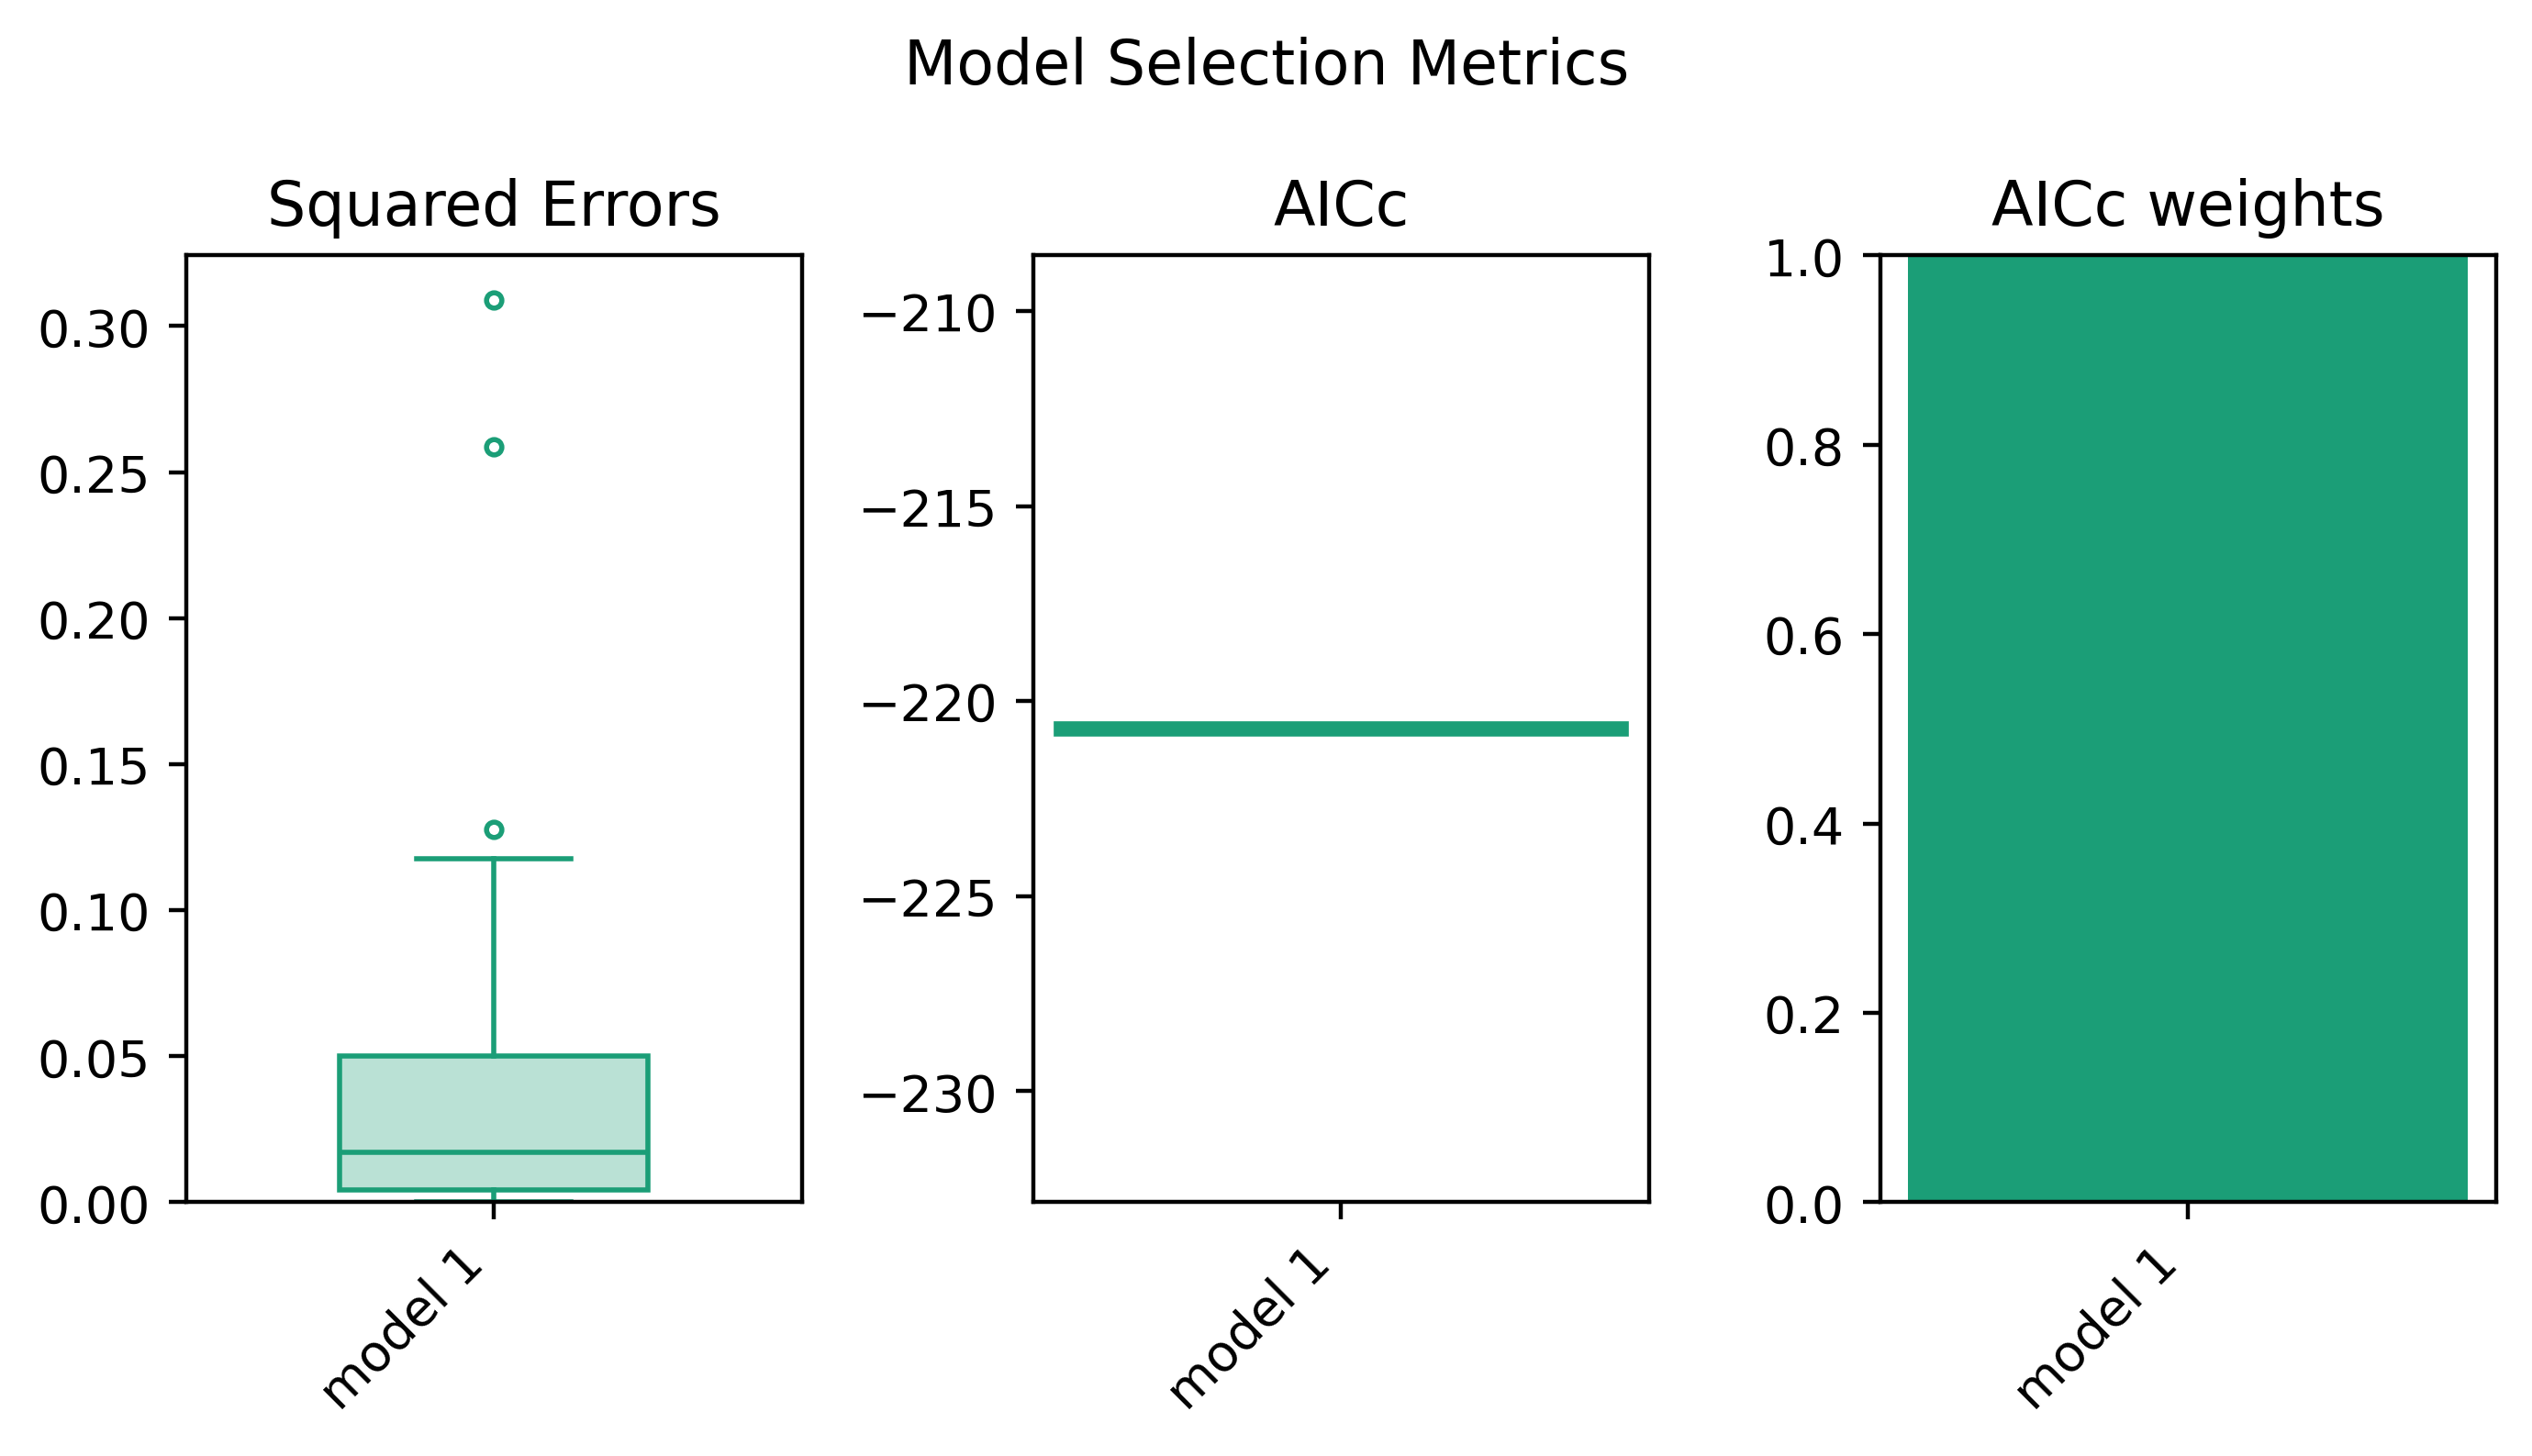

Results for group EMCI:
NDM {'optimal_seed': {'seed': 'Inferiortemporal'}, 'min_timepoint_index': np.int64(43), 'SSE': np.float64(2.5677088851455947), 'r': np.float64(0.7141830528085821), 'AICc':      Model        AICc  AICc weights  rank
0  model 1 -220.710662           1.0     1, 'prediction': array([0.74961391, 0.12410972, 0.13351517, 0.38480741, 0.7215902 ,
       0.81665797, 0.50684204, 1.        , 0.36530326, 0.55842926,
       0.11393103, 0.51162552, 0.11157892, 0.92863895, 0.59356842,
       0.17338826, 0.13927498, 0.09257595, 0.10698759, 0.43425532,
       0.22511842, 0.20100491, 0.17955669, 0.33199101, 0.10392892,
       0.10625832, 0.12785061, 0.35621887, 0.68225906, 0.3788599 ,
       0.08807597, 0.85810146, 0.57300861, 0.2970419 , 0.65061491,
       0.11837648, 0.12724776, 0.39021929, 0.76418201, 0.79540174,
       0.49811819, 0.93532728, 0.36283635, 0.54504815, 0.12263635,
       0.48524628, 0.09704549, 0.81676463, 0.61218204, 0.17641206,
       0.13376491, 0.09932645, 0.

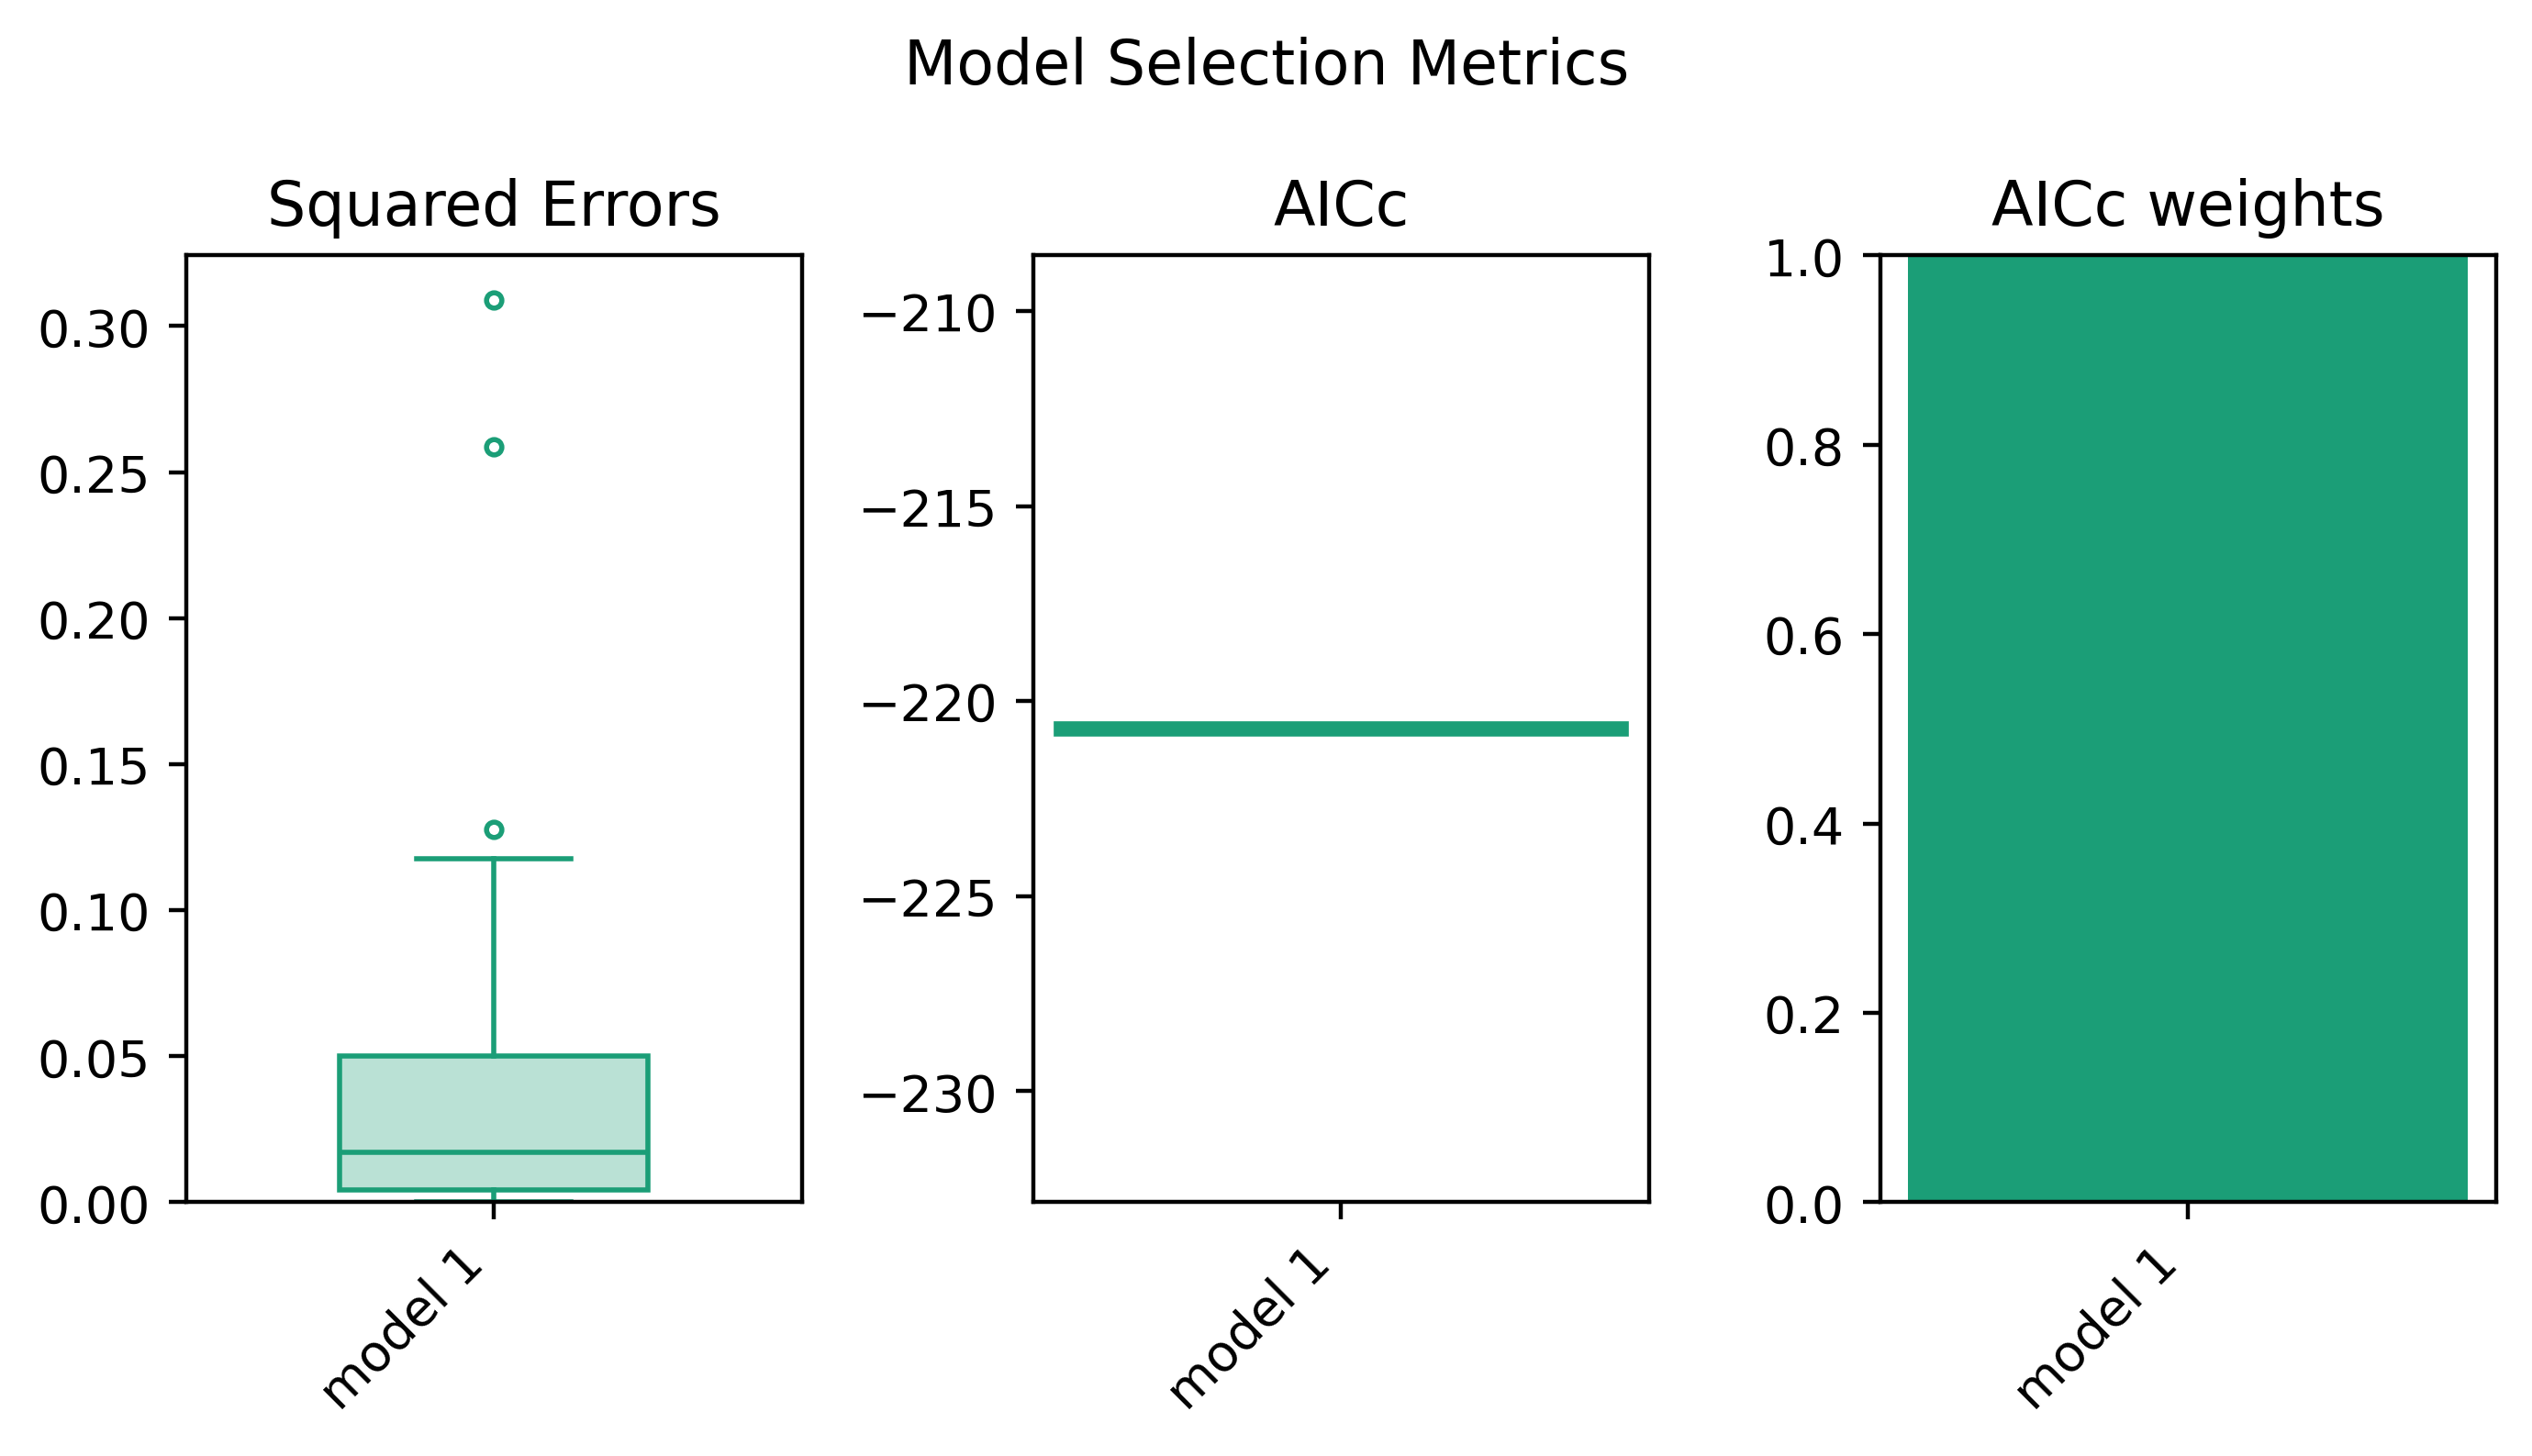

Results for group LMCI:
NDM {'optimal_seed': {'seed': 'Inferiortemporal'}, 'min_timepoint_index': np.int64(43), 'SSE': np.float64(2.5677088851455947), 'r': np.float64(0.7141830528085821), 'AICc':      Model        AICc  AICc weights  rank
0  model 1 -220.710662           1.0     1, 'prediction': array([0.74961391, 0.12410972, 0.13351517, 0.38480741, 0.7215902 ,
       0.81665797, 0.50684204, 1.        , 0.36530326, 0.55842926,
       0.11393103, 0.51162552, 0.11157892, 0.92863895, 0.59356842,
       0.17338826, 0.13927498, 0.09257595, 0.10698759, 0.43425532,
       0.22511842, 0.20100491, 0.17955669, 0.33199101, 0.10392892,
       0.10625832, 0.12785061, 0.35621887, 0.68225906, 0.3788599 ,
       0.08807597, 0.85810146, 0.57300861, 0.2970419 , 0.65061491,
       0.11837648, 0.12724776, 0.39021929, 0.76418201, 0.79540174,
       0.49811819, 0.93532728, 0.36283635, 0.54504815, 0.12263635,
       0.48524628, 0.09704549, 0.81676463, 0.61218204, 0.17641206,
       0.13376491, 0.09932645, 0.

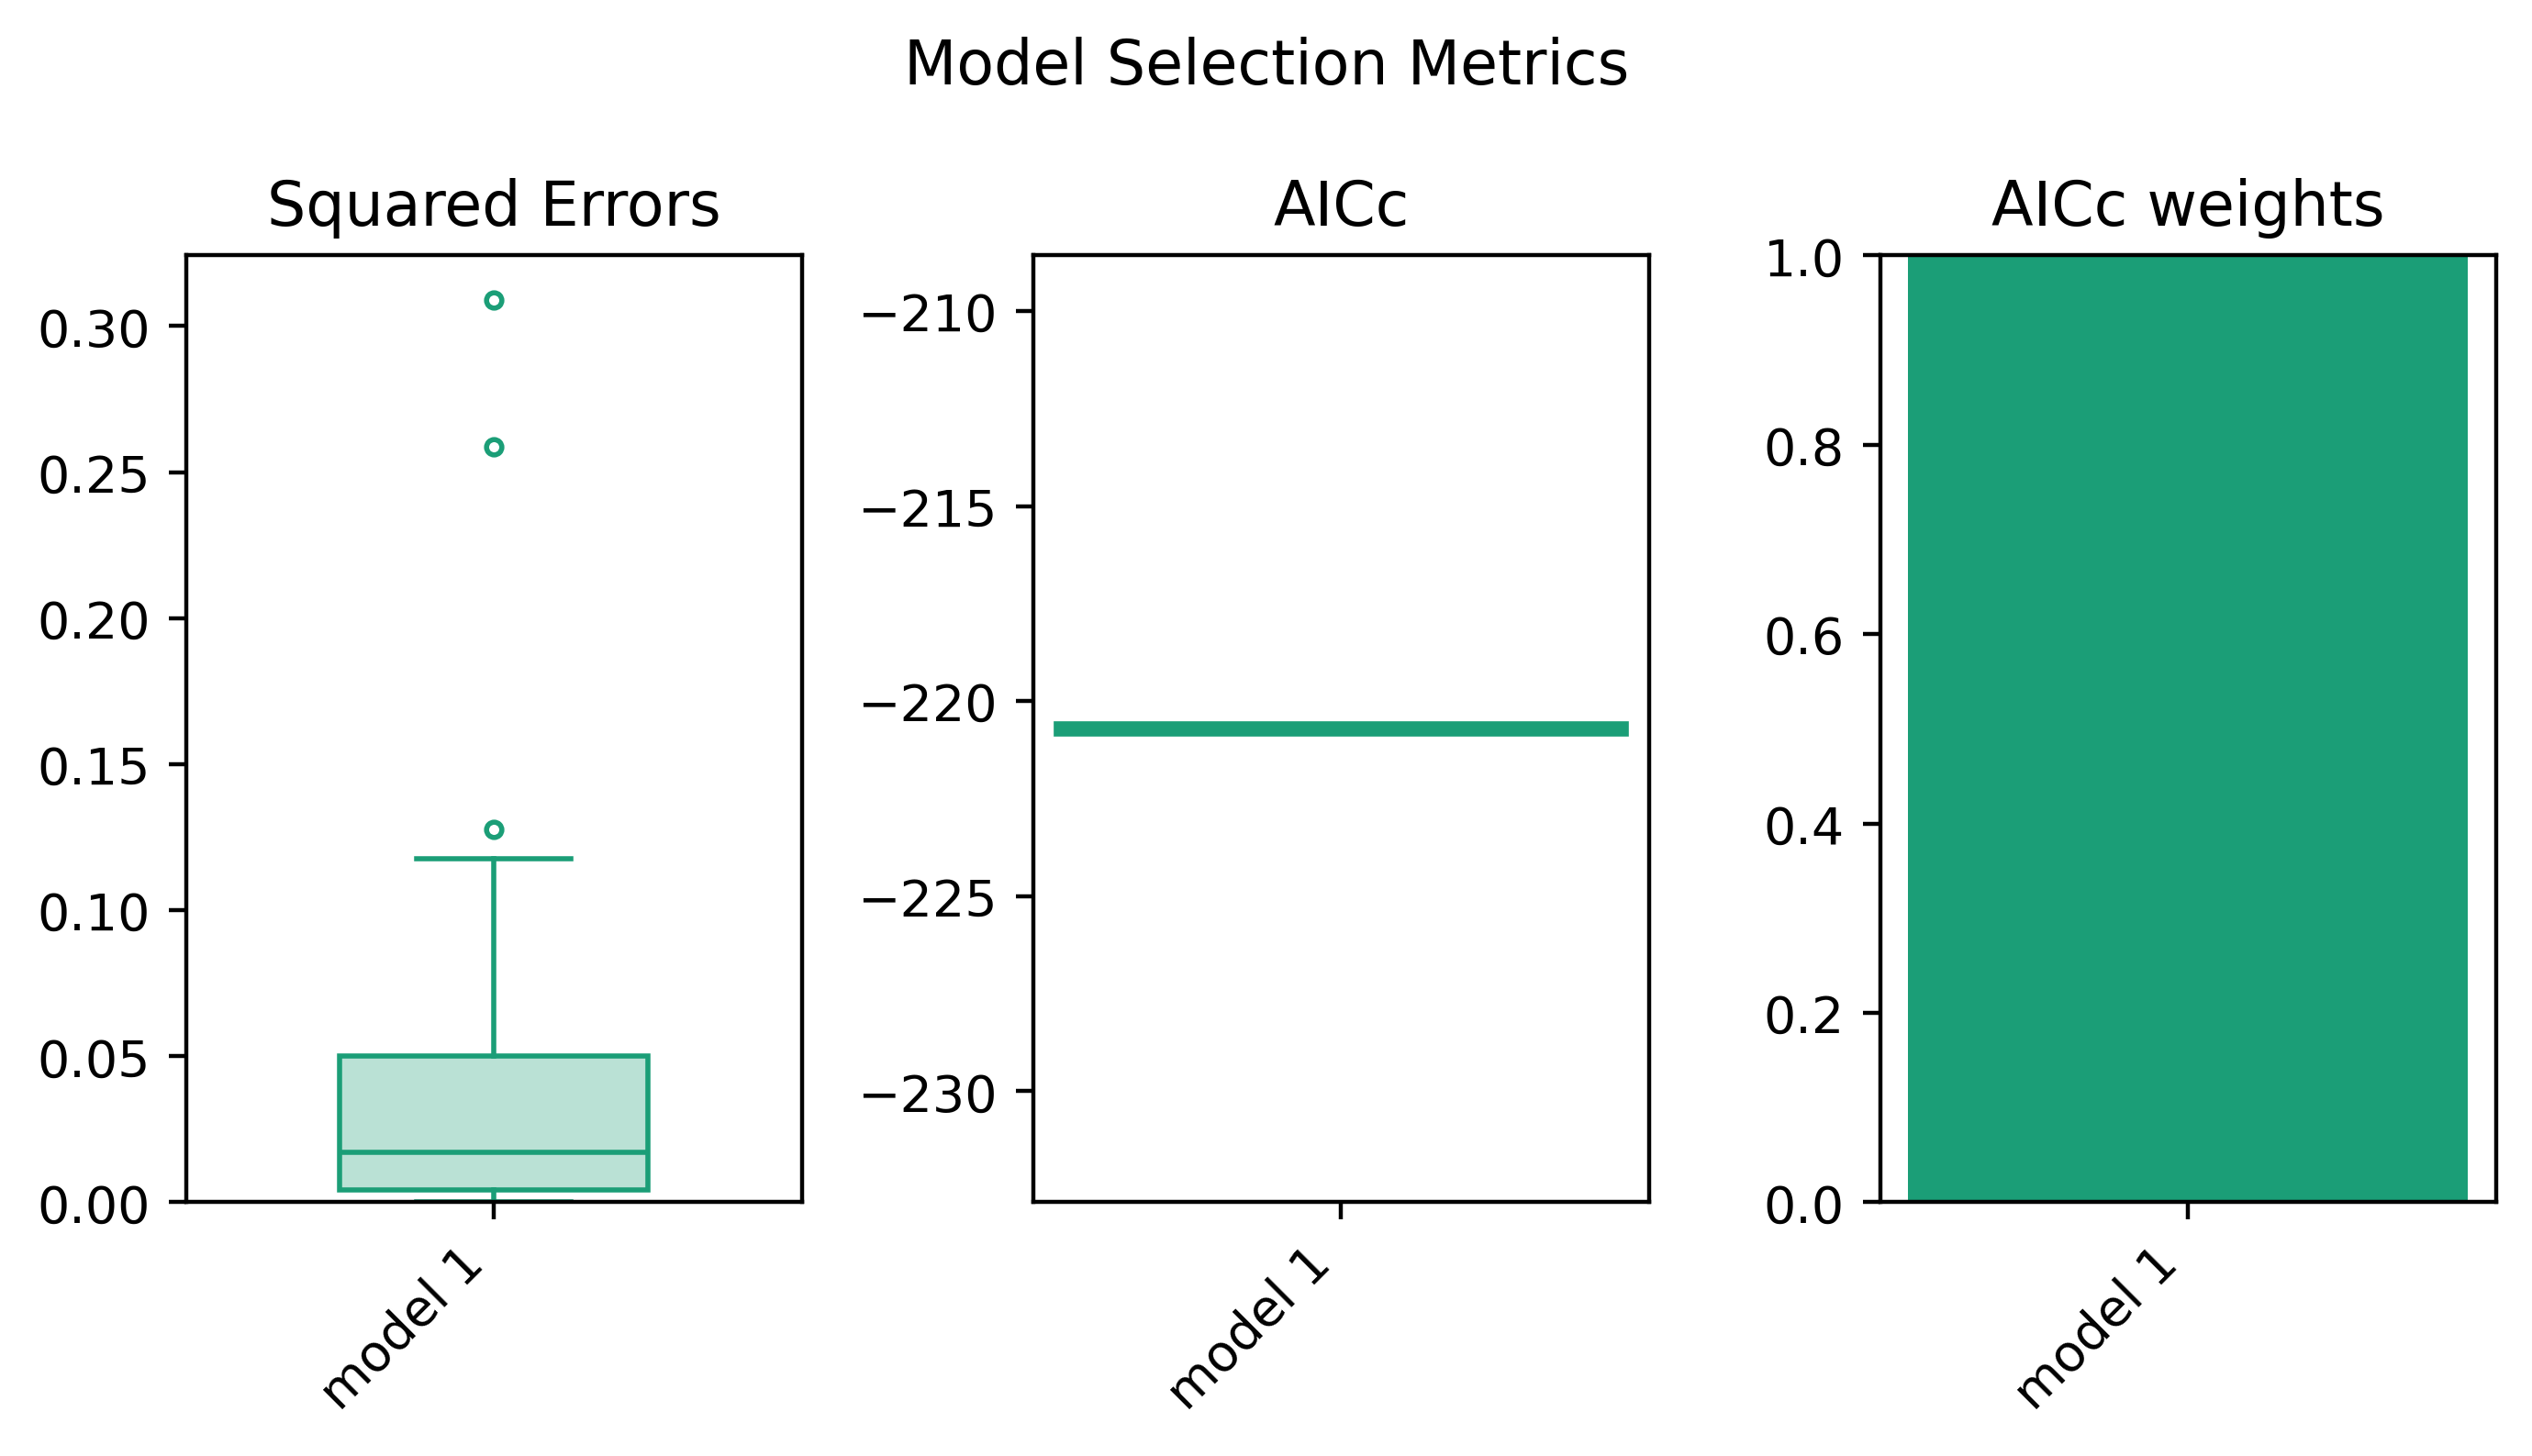

Results for group DEM:
NDM {'optimal_seed': {'seed': 'Inferiortemporal'}, 'min_timepoint_index': np.int64(43), 'SSE': np.float64(2.5677088851455947), 'r': np.float64(0.7141830528085821), 'AICc':      Model        AICc  AICc weights  rank
0  model 1 -220.710662           1.0     1, 'prediction': array([0.74961391, 0.12410972, 0.13351517, 0.38480741, 0.7215902 ,
       0.81665797, 0.50684204, 1.        , 0.36530326, 0.55842926,
       0.11393103, 0.51162552, 0.11157892, 0.92863895, 0.59356842,
       0.17338826, 0.13927498, 0.09257595, 0.10698759, 0.43425532,
       0.22511842, 0.20100491, 0.17955669, 0.33199101, 0.10392892,
       0.10625832, 0.12785061, 0.35621887, 0.68225906, 0.3788599 ,
       0.08807597, 0.85810146, 0.57300861, 0.2970419 , 0.65061491,
       0.11837648, 0.12724776, 0.39021929, 0.76418201, 0.79540174,
       0.49811819, 0.93532728, 0.36283635, 0.54504815, 0.12263635,
       0.48524628, 0.09704549, 0.81676463, 0.61218204, 0.17641206,
       0.13376491, 0.09932645, 0.1

In [9]:
ndm_results = {}

t = np.arange(0, 50, 0.1)
gamma = 1

for group in groups:
    print(f"Processing group: {group}")

    # ----- NDM ------
    ndm = network_diffusion_model.NDM(connectome_fname = group_avg_path,
                                     t=t, gamma=gamma, ref_list = region_list)
    df_ndm, optimal_seed_ndm = ndm.optimise_seed_region(target_data)
    print(f"NDM optimal seed for {group}: {optimal_seed_ndm}")

    # set optimal seed & run
    ndm.seed_region = optimal_seed_ndm["seed"]
    ndm_output = ndm.run_NDM()

    # find timepoint
    min_idx_ndm, prediction_ndm, SSE_ndm = find_optimal_timepoint(ndm_output, target_data)

    # compute pearsons corr
    r_ndm = np.corrcoef(prediction_ndm, target_data)[0,1]

    # calculate residuals & AICc for NDM
    ndm_residuals = (target_data - prediction_ndm).reshape(-1,1)
    ndm_num_params = [1]
    aicc_ndm = ModelSelection(ndm_num_params, 'AICc')(ndm_residuals)

    # store results
    ndm_results[group] = {
            "optimal_seed": optimal_seed_ndm,
            "min_timepoint_index": min_idx_ndm,
            "SSE": SSE_ndm,
            "r": r_ndm,
            "AICc": aicc_ndm,
            "prediction": prediction_ndm,
    }

    print(f"Results for group {group}:")
    print("NDM", ndm_results[group])
    print("-" * 40)

Processing group: CN
NDM optimal seed for CN: {'seed': 'Inferiortemporal'}


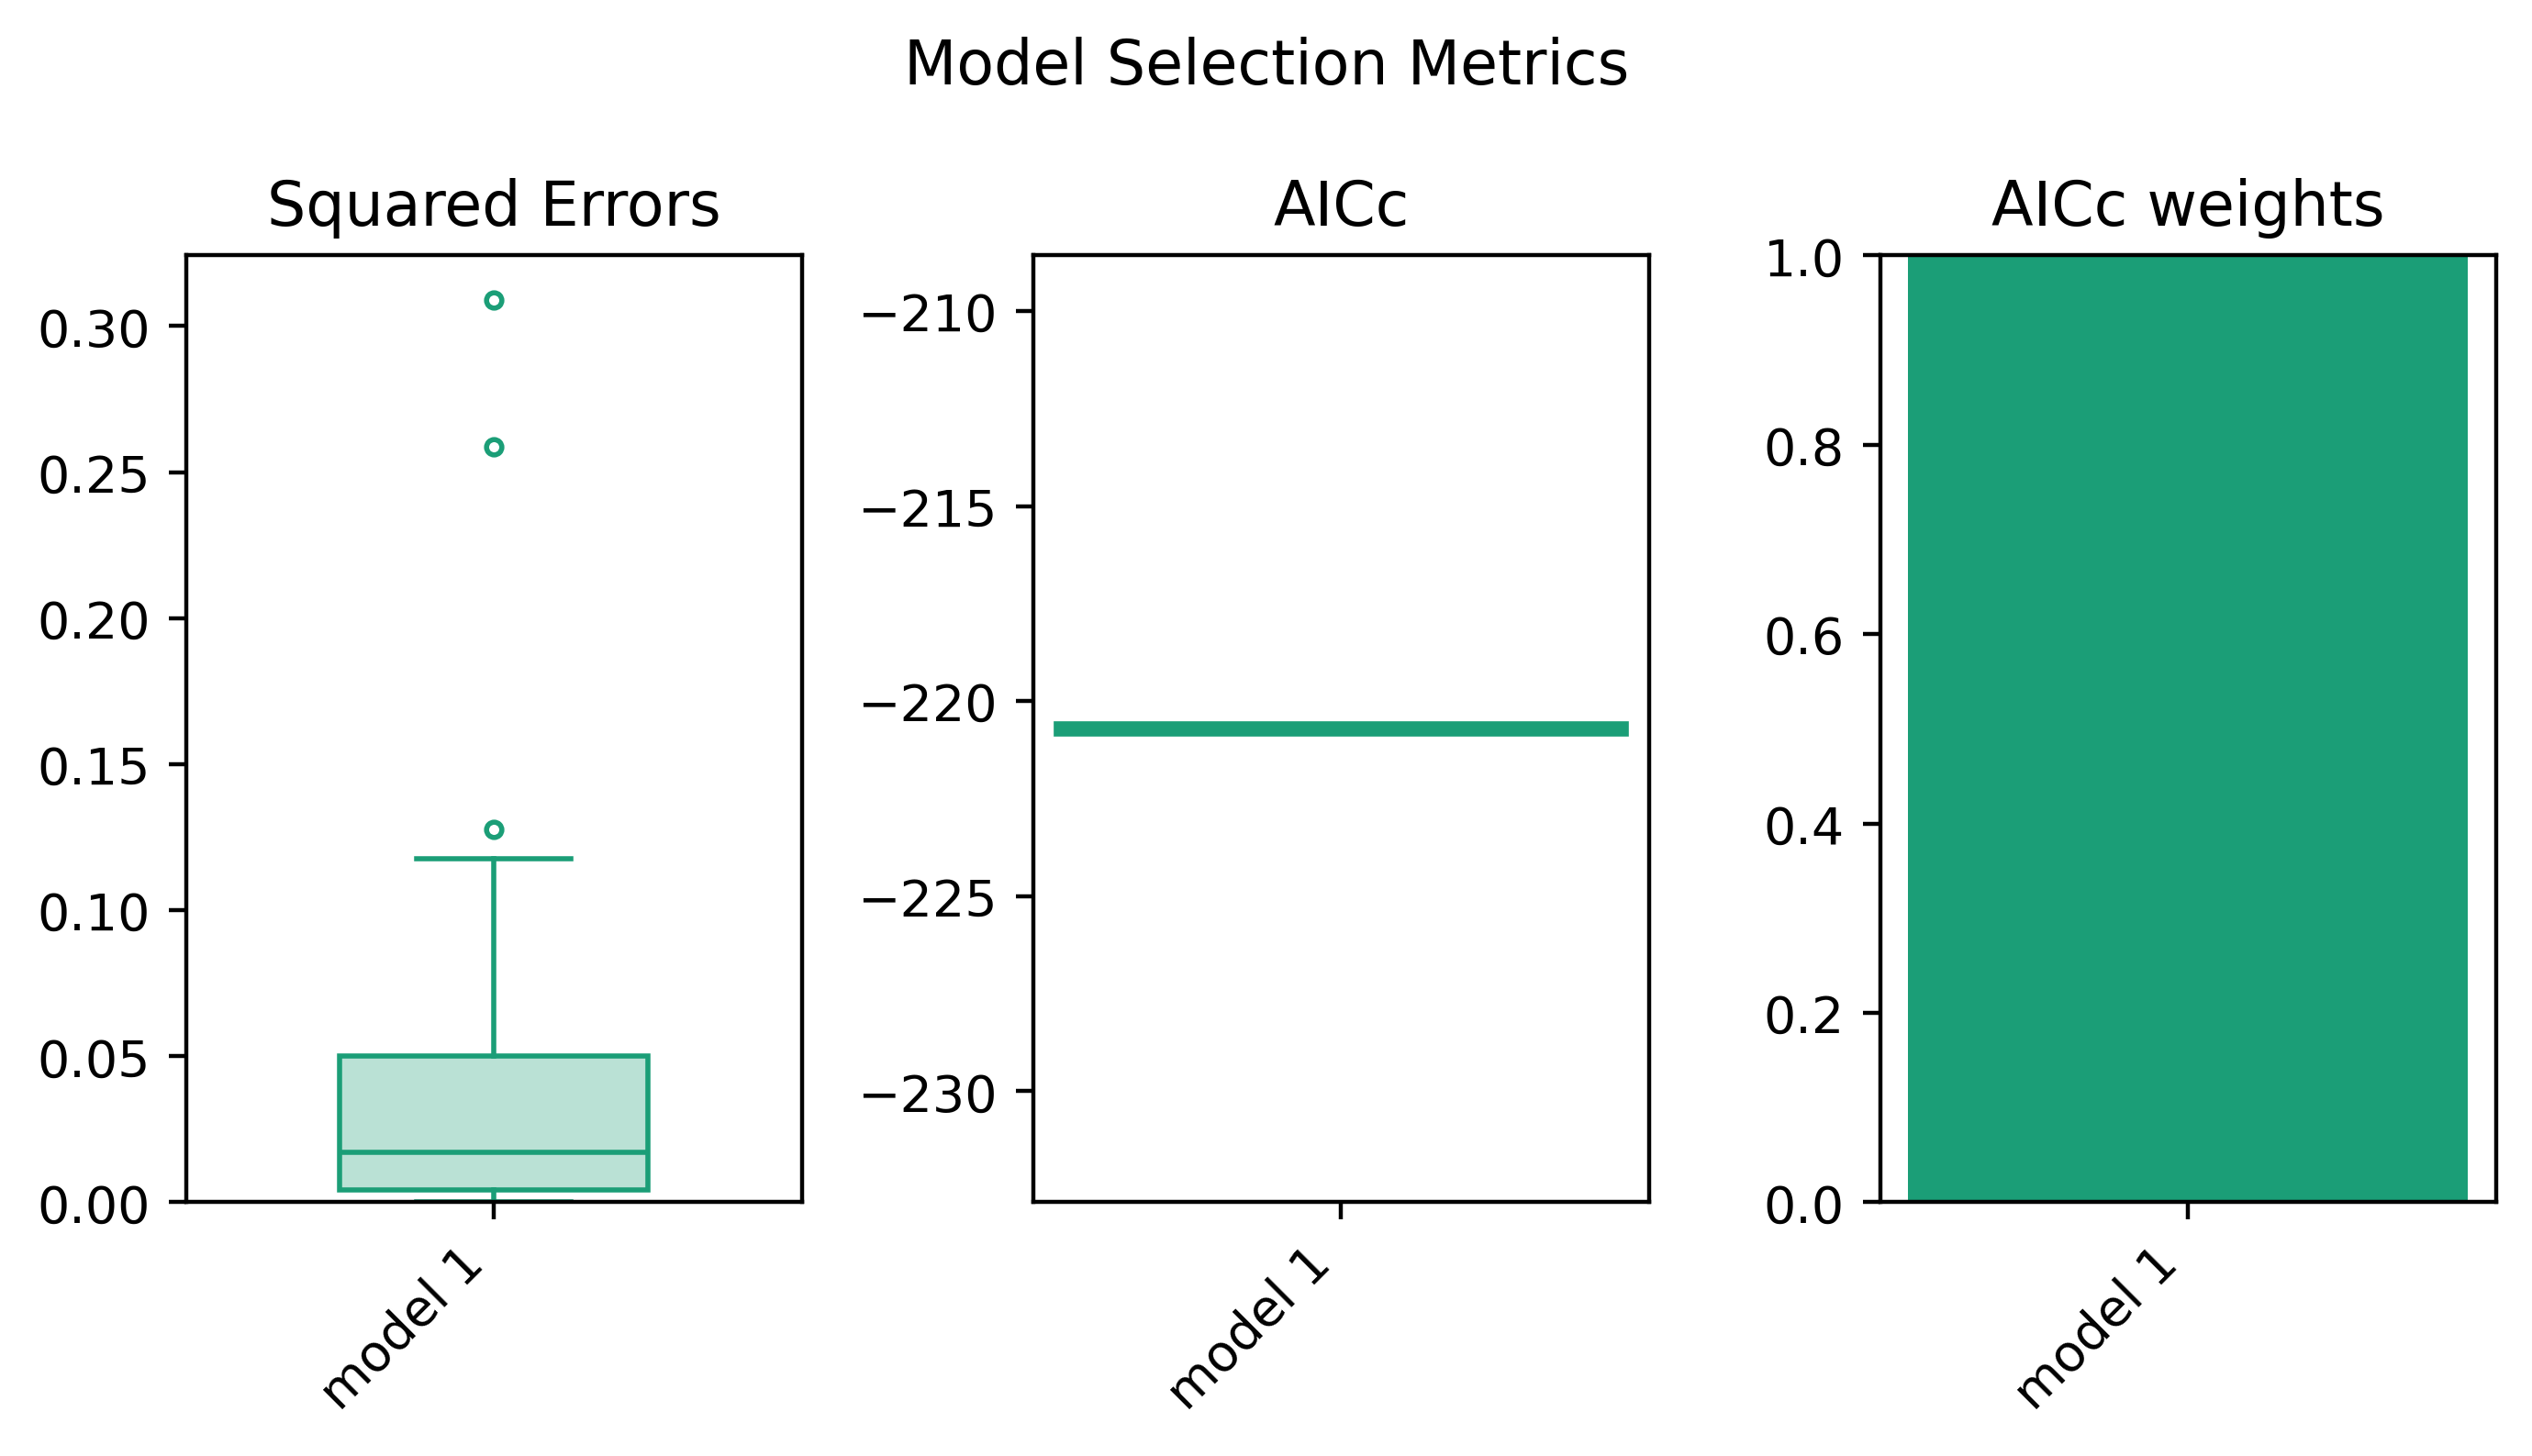

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/ariannaparada/miniconda3/envs/cmbi_env_win/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3546, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/88/27mws8mx02qdqd8pk9dp1pg00000gn/T/ipykernel_86370/1104410604.py", line 38, in <module>
    df_fkpp, optimal_seed_fkpp = fkpp.optimise_fkpp(target_data)
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ariannaparada/Desktop/UCL/Masters/CMBI/CMBI_project_clean/nsm_toolbox/src/FKPP_model.py", line 77, in optimise_fkpp
    res = gp_minimize(objective, dimensions=space,
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ariannaparada/miniconda3/envs/cmbi_env_win/lib/python3.11/site-packages/skopt/optimizer/gp.py", line 281, in gp_minimize
    return base_minimize(
           ^^^^^^^^^^^^^^
  File "/Users/ariannaparada/miniconda3/envs/cmbi_env_win/lib/python3.11/site-packages/skopt/optimizer/ba

In [6]:
fkpp_results = {}

t = np.arange(0, 50, 0.1)
gamma = 1

for group in groups:
    print(f"Processing group: {group}")

    # ------ FKPP ------
    # initialise
    fkpp = FKPP_model.FKPP(connectome_fname=group_avg_path,
                            t=t,
                            gamma=gamma,
                            ref_list=region_list)

    # optimal seed
    df_fkpp, optimal_seed_fkpp, optimal_alpha = fkpp.optimise_fkpp(target_data)

    print(f"FKPP optimal seed for {group}: {optimal_seed_fkpp} and alpha: {optimal_alpha}")

    # optimal params & run
    fkpp.seed_region = optimal_seed_fkpp["seed"]
    fkpp.alpha = optimal_alpha
    fkpp_output = fkpp.run_FKPP()

    # optimal timepoint
    min_idx_fkpp, prediction_fkpp, SSE_fkpp = find_optimal_timepoint(fkpp_output, target_data)

    # pearsons corr
    r_fkpp = np.corrcoef(prediction_fkpp, target_data)[0,1]

    # calculate residuals & AICc for FKPP
    fkpp_residuals = (target_data - prediction_fkpp).reshape(-1,1)
    fkpp_num_params = [2]
    aicc_fkpp = ModelSelection(fkpp_num_params, 'AICc')(fkpp_residuals)

    # store results
    model_results[group] = {
            "optimal_seed": optimal_seed_fkpp,
            "optimal_alpha": optimal_alpha,
            "min_timepoint_index": min_idx_fkpp,
            "SSE": SSE_fkpp,
            "r": r_fkpp,
            "AICc": aicc_fkpp,
            "prediction": prediction_fkpp,
    }

    print(f"Results for group {group}:")
    print("FKPP", fkpp_results[group])
    print("-" * 40)

## Comparison

In [34]:
# compare AICc values across groups & models
print("Summary of model performance:")
for group, res in model_results.items():
    try:
        aicc_ndm_val = float(res["NDM"]["AICc"])
        ndm_aicc_str = f"{aicc_ndm_val:.3f}"
    except Exception:
        ndm_aicc_str = str(res["NDM"]["AICc"])

    try:
        aicc_fkpp_val = float(res["FKPP"]["AICc"])
        fkpp_aicc_str = f"{aicc_fkpp_val:.3f}"
    except Exception:
        fkpp_aicc_str = str(res["FKPP"]["AICc"])
    
    print(f"Group: {group}")
    print(f" NDM -> r: {res['NDM']['r']:.3f}, SSE: {res['NDM']['SSE']:.3f}, AICc: {ndm_aicc_str}")
    print(f" FKPP -> r: {res['FKPP']['r']:.3f}, SSE: {res['FKPP']['SSE']:.3f}, AICc: {fkpp_aicc_str}")
    print('-' * 40)


Summary of model performance:
Group: CN
 NDM -> r: 0.602, SSE: 2.573, AICc:      Model        AICc  AICc weights  rank
0  model 1 -220.558518           1.0     1
 FKPP -> r: 0.606, SSE: 12.563, AICc:      Model       AICc  AICc weights  rank
0  model 1 -110.52812           1.0     1
----------------------------------------
Group: EMCI
 NDM -> r: 0.602, SSE: 2.573, AICc:      Model        AICc  AICc weights  rank
0  model 1 -220.558518           1.0     1
 FKPP -> r: 0.606, SSE: 12.563, AICc:      Model       AICc  AICc weights  rank
0  model 1 -110.52812           1.0     1
----------------------------------------
Group: LMCI
 NDM -> r: 0.602, SSE: 2.573, AICc:      Model        AICc  AICc weights  rank
0  model 1 -220.558518           1.0     1
 FKPP -> r: 0.606, SSE: 12.563, AICc:      Model       AICc  AICc weights  rank
0  model 1 -110.52812           1.0     1
----------------------------------------
Group: DEM
 NDM -> r: 0.602, SSE: 2.573, AICc:      Model        AICc  AICc weigh

## Visualisation

In [35]:
import enigma_toolbox.visualization as engima_vis

for group in groups:
    residuals_ndm = target_data - model_results[group]["NDM"]["prediction"]
    residuals_fkpp = target_data - model_results[group]["FKPP"]["prediction"]

    enigma_vis.plot_cortical_surface(residuals_ndm, region_list, title=f"{group} NDM Residuals")
    enigma_vis.plot_cortical_surface(residuals_fkpp, region_list, title=f"{group} FKPP Residuals")

    print(f"Visualizations for group {group}")

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/ariannaparada/opt/anaconda3/envs/cmbi_env_win/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3546, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/88/27mws8mx02qdqd8pk9dp1pg00000gn/T/ipykernel_67852/1484705383.py", line 1, in <module>
    import enigma_toolbox.visualization as engima_vis
ModuleNotFoundError: No module named 'enigma_toolbox'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/ariannaparada/opt/anaconda3/envs/cmbi_env_win/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2170, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ariannaparada/opt/anaconda3/envs/cmbi_env_win/lib/python3.11/site-packages/IPython/core/ultratb.py", line 1182, in structured_traceback
    return FormattedTB.structured_t